# Neural SDE

This example constructs a neural SDE as a generative time series model.

An SDE is, of course, random: it defines some distribution. Each sample is a whole path. Thus in modern machine learning parlance, an SDE is a generative time series model. This means it can be trained as a GAN, for example. This does mean we need a discriminator that consumes a path as an input; we use a CDE.

Training an SDE as a GAN is precisely what this example does. Doing so will reproduce the following toy example, which is trained on irregularly-sampled time series:

![ou](../imgs/neural_sde.png)

**References:**

Training SDEs as GANs:
```bibtex
@inproceedings{kidger2021sde1,
    title={{N}eural {SDE}s as {I}nfinite-{D}imensional {GAN}s},
    author={Kidger, Patrick and Foster, James and Li, Xuechen and Lyons, Terry J},
    booktitle = {Proceedings of the 38th International Conference on Machine Learning},
    pages = {5453--5463},
    year = {2021},
    volume = {139},
    series = {Proceedings of Machine Learning Research},
    publisher = {PMLR},
}
```

Improved training techniques:
```bibtex
@incollection{kidger2021sde2,
    title={{E}fficient and {A}ccurate {G}radients for {N}eural {SDE}s},
    author={Kidger, Patrick and Foster, James and Li, Xuechen and Lyons, Terry},
    booktitle = {Advances in Neural Information Processing Systems 34},
    year = {2021},
    publisher = {Curran Associates, Inc.},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_sde.ipynb).

!!! warning

    This example will need a GPU to run efficiently.

!!! danger "Advanced example"

    This is an advanced example, due to the complexity of the modelling techniques used.

In [1]:
from typing import Union

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

LipSwish activation functions are a good choice for the discriminator of an SDE-GAN. (Their use here was introduced in the second reference above.)
For simplicity we will actually use LipSwish activations everywhere, even in the generator.

In [2]:
def lipswish(x):
    return 0.909 * jnn.silu(x)

Now set up the vector fields appearing on the right hand side of each differential equation.

In [3]:
class VectorField(eqx.Module):
    scale: Union[int, jnp.ndarray]
    mlp: eqx.nn.MLP

    def __init__(self, hidden_size, width_size, depth, scale, *, key, **kwargs):
        super().__init__(**kwargs)
        scale_key, mlp_key = jr.split(key)
        if scale:
            self.scale = jr.uniform(scale_key, (hidden_size,), minval=0.9, maxval=1.1)
        else:
            self.scale = 1
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size + 1,
            out_size=hidden_size,
            width_size=width_size,
            depth=depth,
            activation=lipswish,
            final_activation=jnn.tanh,
            key=mlp_key,
        )

    def __call__(self, t, y, args):
        return self.scale * self.mlp(jnp.concatenate([t[None], y]))


class ControlledVectorField(eqx.Module):
    scale: Union[int, jnp.ndarray]
    mlp: eqx.nn.MLP
    control_size: int
    hidden_size: int

    def __init__(
        self, control_size, hidden_size, width_size, depth, scale, *, key, **kwargs
    ):
        super().__init__(**kwargs)
        scale_key, mlp_key = jr.split(key)
        if scale:
            self.scale = jr.uniform(
                scale_key, (hidden_size, control_size), minval=0.9, maxval=1.1
            )
        else:
            self.scale = 1
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size + 1,
            out_size=hidden_size * control_size,
            width_size=width_size,
            depth=depth,
            activation=lipswish,
            final_activation=jnn.tanh,
            key=mlp_key,
        )
        self.control_size = control_size
        self.hidden_size = hidden_size

    def __call__(self, t, y, args):
        return self.scale * self.mlp(jnp.concatenate([t[None], y])).reshape(
            self.hidden_size, self.control_size
        )

Now set up the neural SDE (the generator) and the neural CDE (the discriminator).

- Note the use of very large step sizes. By using a large step size we essentially "bake in" the discretisation. This is quite a standard thing to do to decrease computational costs, when the vector field is a pure neural network. (You can reduce the step size here if you want to -- which will increase the computational cost, of course.)

- Note the `clip_weights` method on the CDE -- this is part of imposing the Lipschitz condition on the discriminator of a Wasserstein GAN.
(The other thing doing this is the use of those LipSwish activation functions we saw earlier)

In [4]:
class NeuralSDE(eqx.Module):
    initial: eqx.nn.MLP
    vf: VectorField  # drift
    cvf: ControlledVectorField  # diffusion
    readout: eqx.nn.Linear
    initial_noise_size: int
    noise_size: int

    def __init__(
        self,
        data_size,
        initial_noise_size,
        noise_size,
        hidden_size,
        width_size,
        depth,
        *,
        key,
        **kwargs,
    ):
        super().__init__(**kwargs)
        initial_key, vf_key, cvf_key, readout_key = jr.split(key, 4)

        self.initial = eqx.nn.MLP(
            initial_noise_size, hidden_size, width_size, depth, key=initial_key
        )
        self.vf = VectorField(hidden_size, width_size, depth, scale=True, key=vf_key)
        self.cvf = ControlledVectorField(
            noise_size, hidden_size, width_size, depth, scale=True, key=cvf_key
        )
        self.readout = eqx.nn.Linear(hidden_size, data_size, key=readout_key)

        self.initial_noise_size = initial_noise_size
        self.noise_size = noise_size

    def __call__(self, ts, *, key):
        t0 = ts[0]
        t1 = ts[-1]
        # Very large dt0 for computational speed
        dt0 = 1.0
        init_key, bm_key = jr.split(key, 2)
        init = jr.normal(init_key, (self.initial_noise_size,))
        control = diffrax.VirtualBrownianTree(
            t0=t0, t1=t1, tol=dt0 / 2, shape=(self.noise_size,), key=bm_key
        )
        vf = diffrax.ODETerm(self.vf)  # Drift term
        cvf = diffrax.ControlTerm(self.cvf, control)  # Diffusion term
        terms = diffrax.MultiTerm(vf, cvf)
        # ReversibleHeun is a cheap choice of SDE solver. We could also use Euler etc.
        solver = diffrax.ReversibleHeun()
        y0 = self.initial(init)
        saveat = diffrax.SaveAt(ts=ts)
        sol = diffrax.diffeqsolve(terms, solver, t0, t1, dt0, y0, saveat=saveat)
        return jax.vmap(self.readout)(sol.ys)


class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    vf: VectorField
    cvf: ControlledVectorField
    readout: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initial_key, vf_key, cvf_key, readout_key = jr.split(key, 4)

        self.initial = eqx.nn.MLP(
            data_size + 1, hidden_size, width_size, depth, key=initial_key
        )
        self.vf = VectorField(hidden_size, width_size, depth, scale=False, key=vf_key)
        self.cvf = ControlledVectorField(
            data_size, hidden_size, width_size, depth, scale=False, key=cvf_key
        )
        self.readout = eqx.nn.Linear(hidden_size, 1, key=readout_key)

    def __call__(self, ts, ys):
        # Interpolate data into a continuous path.
        ys = diffrax.linear_interpolation(
            ts, ys, replace_nans_at_start=0.0, fill_forward_nans_at_end=True
        )
        init = jnp.concatenate([ts[0, None], ys[0]])
        control = diffrax.LinearInterpolation(ts, ys)
        vf = diffrax.ODETerm(self.vf)
        cvf = diffrax.ControlTerm(self.cvf, control)
        terms = diffrax.MultiTerm(vf, cvf)
        solver = diffrax.ReversibleHeun()
        t0 = ts[0]
        t1 = ts[-1]
        dt0 = 1.0
        y0 = self.initial(init)
        # Have the discriminator produce an output at both `t0` *and* `t1`.
        # The output at `t0` has only seen the initial point of a sample. This gives
        # additional supervision to the distribution learnt for the initial condition.
        # The output at `t1` has seen the entire path of a sample. This is needed to
        # actually learn the evolving trajectory.
        saveat = diffrax.SaveAt(t0=True, t1=True)
        sol = diffrax.diffeqsolve(terms, solver, t0, t1, dt0, y0, saveat=saveat)
        return jax.vmap(self.readout)(sol.ys)

    @eqx.filter_jit
    def clip_weights(self):
        leaves, treedef = jax.tree_util.tree_flatten(
            self, is_leaf=lambda x: isinstance(x, eqx.nn.Linear)
        )
        new_leaves = []
        for leaf in leaves:
            if isinstance(leaf, eqx.nn.Linear):
                lim = 1 / leaf.out_features
                leaf = eqx.tree_at(
                    lambda x: x.weight, leaf, leaf.weight.clip(-lim, lim)
                )
            new_leaves.append(leaf)
        return jax.tree_util.tree_unflatten(treedef, new_leaves)

Next, the dataset. This follows the trajectories you can see in the picture above. (Namely positive drift with mean-reversion and time-dependent diffusion.)

In [5]:
@jax.jit
@jax.vmap
def get_data(key):
    bm_key, y0_key, drop_key = jr.split(key, 3)

    mu = 0.02
    theta = 0.1
    sigma = 0.4

    t0 = 0
    t1 = 63
    t_size = 64

    def drift(t, y, args):
        return mu * t - theta * y

    def diffusion(t, y, args):
        return 2 * sigma * t / t1

    bm = diffrax.UnsafeBrownianPath(shape=(), key=bm_key)
    drift = diffrax.ODETerm(drift)
    diffusion = diffrax.ControlTerm(diffusion, bm)
    terms = diffrax.MultiTerm(drift, diffusion)
    solver = diffrax.Euler()
    dt0 = 0.1
    y0 = jr.uniform(y0_key, (1,), minval=-1, maxval=1)
    ts = jnp.linspace(t0, t1, t_size)
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        terms, solver, t0, t1, dt0, y0, saveat=saveat, adjoint=diffrax.DirectAdjoint()
    )

    # Make the data irregularly sampled
    to_drop = jr.bernoulli(drop_key, 0.3, (t_size, 1))
    ys = jnp.where(to_drop, jnp.nan, sol.ys)

    return ts, ys


def dataloader(arrays, batch_size, loop, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        key = jr.split(key, 1)[0]
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size
        if not loop:
            break

Now the usual training step for GAN training.

There is one neural-SDE-specific trick here: we increase the update size (i.e. the learning rate) for those parameters describing (and discriminating) the initial condition of the SDE. Otherwise the model tends to focus just on fitting just the rest of the data (i.e. the random evolution over time).

In [6]:
@eqx.filter_jit
def loss(generator, discriminator, ts_i, ys_i, key, step=0):
    batch_size, _ = ts_i.shape
    key = jr.fold_in(key, step)
    key = jr.split(key, batch_size)
    fake_ys_i = jax.vmap(generator)(ts_i, key=key)
    real_score = jax.vmap(discriminator)(ts_i, ys_i)
    fake_score = jax.vmap(discriminator)(ts_i, fake_ys_i)
    return jnp.mean(real_score - fake_score)


@eqx.filter_grad
def grad_loss(g_d, ts_i, ys_i, key, step):
    generator, discriminator = g_d
    return loss(generator, discriminator, ts_i, ys_i, key, step)


def increase_update_initial(updates):
    get_initial_leaves = lambda u: jax.tree_util.tree_leaves(u.initial)
    return eqx.tree_at(get_initial_leaves, updates, replace_fn=lambda x: x * 10)


@eqx.filter_jit
def make_step(
    generator,
    discriminator,
    g_opt_state,
    d_opt_state,
    g_optim,
    d_optim,
    ts_i,
    ys_i,
    key,
    step,
):
    g_grad, d_grad = grad_loss((generator, discriminator), ts_i, ys_i, key, step)
    g_updates, g_opt_state = g_optim.update(g_grad, g_opt_state)
    d_updates, d_opt_state = d_optim.update(d_grad, d_opt_state)
    g_updates = increase_update_initial(g_updates)
    d_updates = increase_update_initial(d_updates)
    generator = eqx.apply_updates(generator, g_updates)
    discriminator = eqx.apply_updates(discriminator, d_updates)
    discriminator = discriminator.clip_weights()
    return generator, discriminator, g_opt_state, d_opt_state

This is our main entry point. Try running `main()`.

In [7]:
def main(
    initial_noise_size=5,
    noise_size=3,
    hidden_size=16,
    width_size=16,
    depth=1,
    generator_lr=2e-5,
    discriminator_lr=1e-4,
    batch_size=1024,
    steps=10000,
    steps_per_print=200,
    dataset_size=8192,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    (
        data_key,
        generator_key,
        discriminator_key,
        dataloader_key,
        train_key,
        evaluate_key,
        sample_key,
    ) = jr.split(key, 7)
    data_key = jr.split(data_key, dataset_size)

    ts, ys = get_data(data_key)
    _, _, data_size = ys.shape

    generator = NeuralSDE(
        data_size,
        initial_noise_size,
        noise_size,
        hidden_size,
        width_size,
        depth,
        key=generator_key,
    )
    discriminator = NeuralCDE(
        data_size, hidden_size, width_size, depth, key=discriminator_key
    )

    g_optim = optax.rmsprop(generator_lr)
    d_optim = optax.rmsprop(-discriminator_lr)
    g_opt_state = g_optim.init(eqx.filter(generator, eqx.is_inexact_array))
    d_opt_state = d_optim.init(eqx.filter(discriminator, eqx.is_inexact_array))

    infinite_dataloader = dataloader(
        (ts, ys), batch_size, loop=True, key=dataloader_key
    )

    for step, (ts_i, ys_i) in zip(range(steps), infinite_dataloader):
        step = jnp.asarray(step)
        generator, discriminator, g_opt_state, d_opt_state = make_step(
            generator,
            discriminator,
            g_opt_state,
            d_opt_state,
            g_optim,
            d_optim,
            ts_i,
            ys_i,
            key,
            step,
        )
        if (step % steps_per_print) == 0 or step == steps - 1:
            total_score = 0
            num_batches = 0
            for ts_i, ys_i in dataloader(
                (ts, ys), batch_size, loop=False, key=evaluate_key
            ):
                score = loss(generator, discriminator, ts_i, ys_i, sample_key)
                total_score += score.item()
                num_batches += 1
            print(f"Step: {step}, Loss: {total_score / num_batches}")

    # Plot samples
    fig, ax = plt.subplots()
    num_samples = min(50, dataset_size)
    ts_to_plot = ts[:num_samples]
    ys_to_plot = ys[:num_samples]

    def _interp(ti, yi):
        return diffrax.linear_interpolation(
            ti, yi, replace_nans_at_start=0.0, fill_forward_nans_at_end=True
        )

    ys_to_plot = jax.vmap(_interp)(ts_to_plot, ys_to_plot)[..., 0]
    ys_sampled = jax.vmap(generator)(ts_to_plot, key=jr.split(sample_key, num_samples))[
        ..., 0
    ]
    kwargs = dict(label="Real")
    for ti, yi in zip(ts_to_plot, ys_to_plot):
        ax.plot(ti, yi, c="dodgerblue", linewidth=0.5, alpha=0.7, **kwargs)
        kwargs = {}
    kwargs = dict(label="Generated")
    for ti, yi in zip(ts_to_plot, ys_sampled):
        ax.plot(ti, yi, c="crimson", linewidth=0.5, alpha=0.7, **kwargs)
        kwargs = {}
    ax.set_title(f"{num_samples} samples from both real and generated distributions.")
    fig.legend()
    fig.tight_layout()
    fig.savefig("neural_sde.png")
    plt.show()

Step: 0, Loss: 0.13390611750738962
Step: 200, Loss: 4.786926678248814
Step: 400, Loss: 7.736175605228969
Step: 600, Loss: 10.103722981044225
Step: 800, Loss: 11.831081799098424
Step: 1000, Loss: 7.418417045048305
Step: 1200, Loss: 6.938951356070382
Step: 1400, Loss: 2.881302390779768
Step: 1600, Loss: 1.5363099915640694
Step: 1800, Loss: 1.0079529796327864
Step: 2000, Loss: 0.936917781829834
Step: 2200, Loss: 0.9594544768333435
Step: 2400, Loss: 1.247592806816101
Step: 2600, Loss: 0.9021680951118469
Step: 2800, Loss: 0.861811808177403
Step: 3000, Loss: 1.1381437267575945
Step: 3200, Loss: 1.5369644505637032
Step: 3400, Loss: 1.3387839964457922
Step: 3600, Loss: 1.0477747491427831
Step: 3800, Loss: 1.7565655538014002
Step: 4000, Loss: 1.8188678196498327
Step: 4200, Loss: 1.4719816957201277
Step: 4400, Loss: 1.4189972026007516
Step: 4600, Loss: 0.6867345826966422
Step: 4800, Loss: 0.6138326355389186
Step: 5000, Loss: 0.5908999613353184
Step: 5200, Loss: 0.579599814755576
Step: 5400, Loss

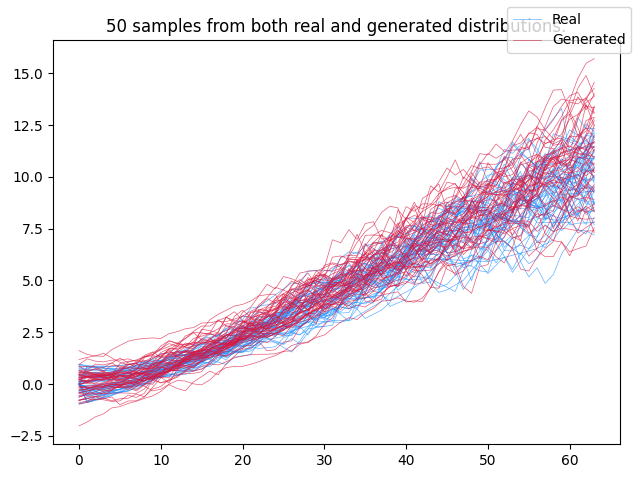

In [8]:
main()